In [ ]:
### LIBRARIES

# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install seaborn
# pip install geopandas
# pip install scikit-learn
# pip install folium
# pip install puLP
# pip install geopy
# pip install scipy
# pip install openpyxl

# Starlink Research
## K-means Clustering and Heatmap Generation for Istanbul

### Elbow Method for Optimal K

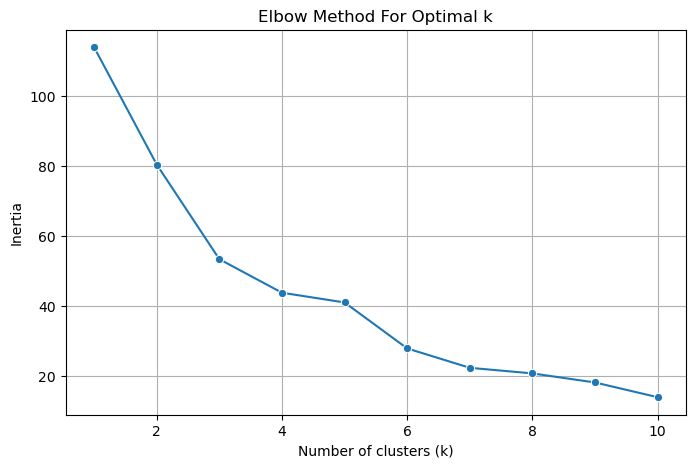

In [ ]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# 2. Load Excel data (skip header row)
df = pd.read_excel("istanbul_population.xlsx", skiprows=1)

# 3. Select features for clustering: Population Density, Latitude, Longitude
X = df.iloc[:, [4, 5, 6]]  # 4: pop density, 5: lat, 6: long

# 4. Optional: normalize if needed (sklearn KMeans handles scale poorly)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Use Elbow Method to find optimal number of clusters
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 6. Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=K_range, y=inertia, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


### District Clustering by Population Density

### Visualise Clusters on a Choropleth

Cluster 0: Likely low-density areas → Potential for expansion

Cluster 1: Medium-density areas → Growing demand

Cluster 2: High-density areas → Priority zones for service deployment

In [ ]:
import pandas as pd
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the Excel file (no headers)
df = pd.read_excel("istanbul_population.xlsx", header=None, skiprows=1)

# Set correct column names
df.columns = [
    'Nr_Plates', 'District', 'Population', 'Area_km2',
    'Population_Density', 'Latitude', 'Longitude'
]

# --- KMeans clustering ---
X = df[['Population_Density', 'Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# --- Plot on folium map ---
m = folium.Map(location=[41.01, 28.95], zoom_start=10)
colors = ['red', 'blue', 'green', 'orange']

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        popup=folium.Popup(f"{row['District']}<br>Cluster {row['Cluster']}", max_width=200),
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

m


### Geocoding: Istanbul Neighborhoods Coordinates

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
import time

# Load your Excel file
df = pd.read_excel("istanbul_population.xlsx", sheet_name="Neighborhoods")  # adjust sheet name if needed

# Set up geopy
geolocator = Nominatim(user_agent="istanbul_geocoder")

# Function to fetch coordinates
def get_coordinates(row):
    try:
        query = f"{row['Neighborhood']}, {row['District']}, Istanbul, Turkey"
        location = geolocator.geocode(query)
        time.sleep(1)  # avoid throttling
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([None, None])

# Apply function
df[['Latitude', 'Longitude']] = df.apply(get_coordinates, axis=1)

# Save the results
df.to_excel("istanbul_neighborhoods_with_coords.xlsx", index=False)
print("✅ Geocoding complete. File saved as istanbul_neighborhoods_with_coords.xlsx")


✅ Geocoding complete. File saved as istanbul_neighborhoods_with_coords.xlsx


### Mapping: Istanbul Neighborhood Clusters

| Cluster ID | Color     | Geographic Distribution                          | Population Density | Interpretation                                         | Service Priority                    |
| ---------- | --------- | ------------------------------------------------ | ------------------ | ------------------------------------------------------ | ----------------------------------- |
| **0**      | 🔴 Red    | Far **north & rural**: Şile, Beykoz, Çatalca     | Low                | **Sparse, rural, forest areas** (low density + remote) | 🔹 Low (hard to serve, few users)   |
| **1**      | 🔵 Blue   | Dense **western core**: Bağcılar, Esenler        | High               | **Urban cores**, highest density, small area           | 🔺 Highest (need intensive service) |
| **2**      | 🟢 Green  | Mixed western & south: Küçükçekmece, Esenyurt    | Medium-High        | **Growing suburbs**, diverse density                   | 🔸 Medium-High                      |
| **3**      | 🟣 Purple | Western periphery: Silivri, Çatalca, rural areas | Low                | **Rural/coastal periphery**, sparse settlements        | 🔹 Low                              |
| **4**      | 🟡 Yellow | Dense **southern band**: Pendik, Kartal, Maltepe | Medium-High        | **Dense residential belts**, transit corridors         | 🔸 Medium-High                      |


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium

# Load data
df = pd.read_excel("istanbul_neighborhoods_with_coords.xlsx")

# Drop missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Select and scale features
X = df[['Population_Density', 'Latitude', 'Longitude']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Create folium map
m = folium.Map(location=[41.0082, 28.9784], zoom_start=10)
colors = ['red', 'blue', 'green', 'purple', 'orange']

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=folium.Popup(f"{row['Neighborhood']} ({row['District']})<br>Cluster {row['Cluster']}", max_width=250),
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m.save("istanbul_neighborhood_clusters.html")
print("✅ Map saved as istanbul_neighborhood_clusters.html")


✅ Map saved as istanbul_neighborhood_clusters.html


### Service Zones According to Earthquake Risks and Income

Zone colors:

🔴 Red: Zone 1 (High Power + High Risk)

🟠 Orange: Zone 2 (Low Power + High Risk)

🟢 Green: Zone 3 (High Power + Low Risk)

⚫ Gray: Other

In [ ]:
import pandas as pd
import folium

# Load the Excel file (replace with your actual file name)
file_path = "istanbul_neighborhoods_with_coords.xlsx"
df = pd.read_excel(file_path)

# Assign purchasing power (proxy by district)
high_income_districts = [
    "Beşiktaş", "Kadıköy", "Sarıyer", "Şişli", "Ataşehir", "Beykoz", "Üsküdar", "Bakırköy"
]
low_income_districts = [
    "Esenler", "Sultangazi", "Arnavutköy", "Bağcılar", "Esenyurt", "Gaziosmanpaşa", "Sultanbeyli"
]
df['Purchasing_Power'] = df['District'].apply(
    lambda d: 'High' if d in high_income_districts else ('Low' if d in low_income_districts else 'Medium')
)

# Assign earthquake risk (proxy by district)
high_risk_districts = [
    "Avcılar", "Bakırköy", "Küçükçekmece", "Zeytinburnu", "Fatih", "Bahçelievler", "Beşiktaş", "Beylikdüzü"
]
df['Earthquake_Risk'] = df['District'].apply(
    lambda d: 'High' if d in high_risk_districts else 'Low'
)

# Assign service zone
def assign_service_zone(row):
    if row['Purchasing_Power'] == 'High' and row['Earthquake_Risk'] == 'High':
        return 'Zone 1: High Power + High Risk'
    elif row['Purchasing_Power'] == 'Low' and row['Earthquake_Risk'] == 'High':
        return 'Zone 2: Low Power + High Risk'
    elif row['Purchasing_Power'] == 'High' and row['Earthquake_Risk'] == 'Low':
        return 'Zone 3: High Power + Low Risk'
    else:
        return 'Other'

df['Service_Zone'] = df.apply(assign_service_zone, axis=1)

# Remove rows with missing coordinates
df_cleaned = df.dropna(subset=['Latitude', 'Longitude'])

# Define zone colors
zone_colors = {
    'Zone 1: High Power + High Risk': 'red',
    'Zone 2: Low Power + High Risk': 'orange',
    'Zone 3: High Power + Low Risk': 'green',
    'Other': 'gray'
}

# Create the Folium map centered on Istanbul
m = folium.Map(location=[41.0082, 28.9784], zoom_start=10)

# Add CircleMarkers
for _, row in df_cleaned.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=4,
        color=zone_colors.get(row['Service_Zone'], 'black'),
        fill=True,
        fill_color=zone_colors.get(row['Service_Zone'], 'black'),
        fill_opacity=0.7,
        popup=f"{row['Neighborhood']} ({row['District']})<br>{row['Service_Zone']}"
    ).add_to(m)

# Save map
m.save("istanbul_service_zones_map.html")
print("✅ Map saved as istanbul_service_zones_map.html")

✅ Map saved as istanbul_service_zones_map.html


## Link-Budget Calculation

\begin{align*}
Link Budget (dB) = P_t(dB)+G_t(dB)+G_τ(dB)-L_p(dB)-L_o(dB)\\
\end{align*}

***Where:***
\begin{align*}
P_t & : \text{Transmitted power (in dB)} \\
G_t & : \text{Gain of the transmitting antenna (in dB)} \\
G_r & : \text{Gain of the receiving antenna (in dB)} \\
L_p & : \text{Path loss (in dB), calculated as:} \\
& \quad L_p = 20 \log_{10}(d) + 20 \log_{10}(f) + 147.55 \quad \text{(free-space loss)} \\
L_o & : \text{Other losses (in dB), e.g., atmospheric attenuation, cable losses, polarization mismatch}
\end{align*}

In [ ]:
import numpy as np

# ----------------------------
# Starlink Link Budget Parameters
# ----------------------------
P_t = 33         # dBW, EIRP (already includes G_t)
G_r = 33         # dBi, Receiving terminal gain
L_o = 3          # dB, Atmospheric + Cable + Polarization loss
P_r_min = -100   # dBm, Minimum acceptable received power
f = 12           # GHz, Ku-band central frequency

# ----------------------------
# Compute Path Loss L_p (in dB) using Link Budget
# ----------------------------
L_p = P_t + G_r - P_r_min - L_o

# ----------------------------
# 📏 Derive max coverage radius from path loss
# L_p = 20 log10(d) + 20 log10(f) + 147.55
# Solve for d
# ----------------------------
log_d = (L_p - 20 * np.log10(f) - 147.55) / 20
d_km = 10 ** log_d

# ----------------------------
# Results
# ----------------------------
print(f"📉 Path Loss (L_p): {L_p:.2f} dB")
print(f"📡 Derived max coverage radius: R ≈ {d_km:.2f} km")
print("🧑‍🤝‍🧑 Max users per dish: 128 (Starlink hardware limit)")


📉 Path Loss (L_p): 163.00 dB
📡 Derived max coverage radius: R ≈ 0.49 km
🧑‍🤝‍🧑 Max users per dish: 128 (Starlink hardware limit)


## Linear Programming Formulation (Set Cover for Starlink Service Zones)

\begin{align*}
\mbox{minimize} \;\;& \sum\limits_{j \in J} x_{j} \\
\mbox{subject to:} \;\;& y_{i} \leq \sum\limits_{j \in J} z_{ij} x_{j} \;\;\;\; i = 1, 2, \dots, N\\
\;\;& \sum\limits_{i \in I}^{N} P_{i} y_{i} \geq 0.95 \sum\limits_{i \in I}^{N} P_{i} \;\;\;\; j = 1, 2, \dots, N\\
\;\;& x_{j},y_{i} \in \{0, 1\} \;\;\;\; i = 1, 2, \dots, N; j = 1, 2, \dots, N\\
\;\;& z_{ij} = 1, \;\;\;\; if d_{ij} \leq R (calculated from link-budget) \\
\;\;& z_{ij} = 0, \;\;\;\; otherwise\\
\end{align*}

In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD
from geopy.distance import geodesic

# Load data
df = pd.read_excel("istanbul_neighborhoods_with_coords.xlsx")
service_points = pd.read_excel("istanbul_service_points.xlsx")

# Drop missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Parameters
R = 0.49  # Coverage radius in km (example)
demand_points = df[['Neighborhood', 'District', 'Latitude', 'Longitude', 'Population']].reset_index(drop=True)

# Calculate coverage matrix
coverage = {}
for i, d in demand_points.iterrows():
    for j, s in service_points.iterrows():
        dist = geodesic((d['Latitude'], d['Longitude']), (s['Latitude'], s['Longitude'])).km
        if dist <= R:
            coverage.setdefault(i, []).append(j)

# PuLP Model
model = LpProblem("Starlink_Set_Covering", LpMinimize)
x = {j: LpVariable(f"x_{j}", cat=LpBinary) for j in service_points.index}
y = {i: LpVariable(f"y_{i}", cat=LpBinary) for i in demand_points.index}

# Objective: Minimize site count
model += lpSum(x[j] for j in x)

# Constraint 1: Coverage assignment
for i in y:
    if i in coverage:
        model += y[i] <= lpSum(x[j] for j in coverage[i])
    else:
        model += y[i] == 0  # No coverage

# Constraint 2: ≥95% population covered
total_pop = demand_points['Population'].sum()
model += lpSum(demand_points.loc[i, 'Population'] * y[i] for i in y) >= 0.95 * total_pop

# Solve
solver = PULP_CBC_CMD(msg=True)
model.solve(solver)

# Results
covered_sites = [j for j in x if x[j].varValue > 0.5]
print(f"✅ Optimal sites: {covered_sites}")
print(f"Sites placed at coordinates:\n{service_points.loc[covered_sites, ['Latitude', 'Longitude']]}")

# Greedy heuristic fallback: sort by population covered
site_coverage = []
for j in service_points.index:
    covered_pop = sum(
        demand_points.loc[i, 'Population']
        for i in coverage if j in coverage[i]
    )
    site_coverage.append((j, covered_pop))

site_coverage = sorted(site_coverage, key=lambda x: -x[1])
greedy_sites = [j for j, _ in site_coverage[:5]]

print(f"🛡️ Greedy fallback sites: {greedy_sites}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h_/29lmqv9s4f36q40k87jyfcp40000gn/T/e47e02e455374bb88a679385ebf1ec4e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h_/29lmqv9s4f36q40k87jyfcp40000gn/T/e47e02e455374bb88a679385ebf1ec4e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 927 COLUMNS
At line 4628 RHS
At line 5551 BOUNDS
At line 6478 ENDATA
Problem MODEL has 922 rows, 926 columns and 1843 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.02

✅ Optimal sites: []
Sites placed at coordinates:
Empty DataFrame
Columns: [Latitude, Longitude]
Index: []
🛡️ Greedy fallback sites: [3, 0, 1, 2, 4]


## Set-Cover Model
### Minimum number of facilities that cover more than 95% of the Istanbul population

In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD
from geopy.distance import geodesic

# ----------------------
# INPUT: Load data
# ----------------------
df = pd.read_excel("istanbul_neighborhoods_with_coords.xlsx")
service_points = pd.read_excel("istanbul_service_points.xlsx")
df = df.dropna(subset=['Latitude', 'Longitude'])

# ----------------------
# LINK BUDGET PARAMETERS (Ku-band)
# ----------------------
P_t = 33         # dBW, EIRP (already includes G_t)
G_r = 33         # dBi, Receiving terminal gain
L_o = 3          # dB, Atmospheric + Cable + Polarization loss
P_r_min = -100   # dBm, Minimum acceptable received power
f = 12           # GHz, Ku-band central frequency

# Compute path loss
L_p = P_t + G_r - P_r_min - L_o
log_d = (L_p - 20 * np.log10(f) - 147.55) / 20
R = 10 ** log_d  # ➡️ This is the MAX range in km
print(f"📡 Link-budget derived coverage radius: R ≈ {R:.2f} km")

# ----------------------
# COVERAGE MATRIX
# ----------------------
demand_points = df[['Neighborhood', 'District', 'Latitude', 'Longitude', 'Population']].reset_index(drop=True)
coverage = {}
for i, d in demand_points.iterrows():
    for j, s in service_points.iterrows():
        dist = geodesic((d['Latitude'], d['Longitude']), (s['Latitude'], s['Longitude'])).km
        if dist <= R:
            coverage.setdefault(i, []).append(j)

# ----------------------
# SET COVERING MODEL (MILP)
# ----------------------
model = LpProblem("Starlink_Set_Cover", LpMinimize)
x = {j: LpVariable(f"x_{j}", cat=LpBinary) for j in service_points.index}
y = {i: LpVariable(f"y_{i}", cat=LpBinary) for i in demand_points.index}

# Objective: minimize number of dishes
model += lpSum(x[j] for j in x)

# Constraint: demand coverage
for i in y:
    if i in coverage:
        model += y[i] <= lpSum(x[j] for j in coverage[i])
    else:
        model += y[i] == 0

# Constraint: at least 95% population covered
total_pop = demand_points['Population'].sum()
model += lpSum(demand_points.loc[i, 'Population'] * y[i] for i in y) >= 0.95 * total_pop

# Solve
solver = PULP_CBC_CMD(msg=True)
model.solve(solver)

# ----------------------
# RESULTS
# ----------------------
optimal_sites = [j for j in x if x[j].varValue > 0.5]
print(f"\n✅ Optimal sites: {optimal_sites}")
print(service_points.loc[optimal_sites, ['Latitude', 'Longitude']])

# ----------------------
# GREEDY HEURISTIC
# ----------------------
site_coverage = []
for j in service_points.index:
    covered_pop = sum(
        demand_points.loc[i, 'Population']
        for i in coverage if j in coverage[i]
    )
    site_coverage.append((j, covered_pop))

site_coverage = sorted(site_coverage, key=lambda x: -x[1])
greedy_sites = [j for j, _ in site_coverage[:5]]

print(f"\n🛡️ Greedy fallback sites: {greedy_sites}")
print(service_points.loc[greedy_sites, ['Latitude', 'Longitude']])


📡 Link-budget derived coverage radius: R ≈ 0.49 km
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h_/29lmqv9s4f36q40k87jyfcp40000gn/T/742c39c1255e41b5a166d21fe5aac611-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h_/29lmqv9s4f36q40k87jyfcp40000gn/T/742c39c1255e41b5a166d21fe5aac611-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 927 COLUMNS
At line 4628 RHS
At line 5551 BOUNDS
At line 6478 ENDATA
Problem MODEL has 922 rows, 926 columns and 1843 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01


✅ Optimal sites: []
Empty DataFrame
Columns: [Latitude, Longitude]
Index: []

🛡️ Greedy fallback s

## Maximal Covering
### At max 1000 demand points to locate, that covers more than 95% of the Istanbul population

In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD
from geopy.distance import geodesic

# Load data
demand_points = pd.read_excel("istanbul_neighborhoods_with_coords.xlsx")
service_points = pd.read_excel("istanbul_service_points.xlsx")

# Drop missing
demand_points = demand_points.dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)
service_points = service_points.dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)

# Realistic Starlink beam radius (e.g. 15 km)
realistic_radius = 15

# Build coverage matrix
coverage = {}
for i, d in demand_points.iterrows():
    for j, s in service_points.iterrows():
        if geodesic((d['Latitude'], d['Longitude']), (s['Latitude'], s['Longitude'])).km <= realistic_radius:
            coverage.setdefault(i, []).append(j)

# MCLP Model
model = LpProblem("Starlink_Coverage", LpMaximize)

x = {j: LpVariable(f"x_{j}", cat=LpBinary) for j in service_points.index}
y = {i: LpVariable(f"y_{i}", cat=LpBinary) for i in demand_points.index}

# Objective: maximize covered population
model += lpSum(demand_points.loc[i, 'Population'] * y[i] for i in y)

# Constraints
for i in y:
    if i in coverage:
        model += y[i] <= lpSum(x[j] for j in coverage[i])
    else:
        model += y[i] == 0

# Limit number of facilities to 1000
model += lpSum(x[j] for j in x) <= 4

# Solve
model.solve(PULP_CBC_CMD(msg=True))

# Output
optimal_sites = [j for j in x if x[j].varValue > 0.5]
print(f"\n✅ Optimal 4 Sites (15 km radius): {optimal_sites}")
print(service_points.loc[optimal_sites, ['Latitude', 'Longitude']])


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h_/29lmqv9s4f36q40k87jyfcp40000gn/T/50a5710ea9ac4a7495b99a77fb112604-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/h_/29lmqv9s4f36q40k87jyfcp40000gn/T/50a5710ea9ac4a7495b99a77fb112604-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 927 COLUMNS
At line 5484 RHS
At line 6407 BOUNDS
At line 7334 ENDATA
Problem MODEL has 922 rows, 926 columns and 1783 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.39443e+07 - 0.00 seconds
Cgl0002I 147 variables fixed
Cgl0004I processed model has 84 rows, 88 columns (88 integer (88 of which binary)) and 254 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -1.39443e+07
Cbc0038I Before mini branc

In [ ]:
# ✅ Extract covered demand points
covered_demands = [i for i in y if y[i].varValue > 0.5]

# ✅ Print the first few
print(f"\n✅ Covered demand points: {len(covered_demands)}")
print(demand_points.loc[covered_demands, ['Neighborhood', 'District', 'Latitude', 'Longitude', 'Population']])

# ✅ Optional: Save to Excel
demand_points.loc[covered_demands, ['Neighborhood', 'District', 'Latitude', 'Longitude', 'Population']].to_excel("covered_demand_points.xlsx", index=False)



✅ Covered demand points: 733
            Neighborhood     District   Latitude  Longitude  Population
0                Anadolu   Arnavutköy  41.185169  28.749452       33177
1             Yunus Emre   Arnavutköy  41.185192  28.760527       16085
2    Arnavutköy İslambey   Arnavutköy  41.184745  28.741108       18832
3     Mustafa Kemal Paşa   Arnavutköy  41.186827  28.735883       12585
4              Nenehatun   Arnavutköy  41.201834  28.728986        8344
..                   ...          ...        ...        ...         ...
916            Beştelsiz  Zeytinburnu  40.999487  28.904502       23926
917           Seyitnizam  Zeytinburnu  41.006495  28.908933       24113
918         Merkezefendi  Zeytinburnu  41.014371  28.918986       23742
919           Kazlıçeşme  Zeytinburnu  40.992673  28.916890        2078
920              Maltepe  Zeytinburnu  41.027777  28.909692        2592

[733 rows x 5 columns]


## Erlang B Traffic Models

### 📡 Erlang-B Formula (Traffic Engineering)

The **Erlang-B formula** estimates the probability that a call will be blocked in a system with \( N \) servers (or channels) and offered traffic load \( E \) (in Erlangs):

\begin{align*}
B(E,N)= \frac{\frac{E^N}{N!}}{\sum\limits_{k=0}^{N} \frac{E^k}{k!} \\
}\\
\end{align*}



***Where:***
\begin{align*}
B(E,N) & : \text{Blocking probability} \\
E & : \text{Offered traffic (in Erlangs)} \\
N & : \text{Number of Starlink dish channels (capacity)} \\
\end{align*}

---

To find the **maximum number of users per dish** under a given traffic load and acceptable blocking probability, we solve:

\begin{align*}
\text{Find max } N \text{ such that } B(E \cdot U, N) \leq P
\end{align*}

***Where:***
\begin{align*}
U & : \text{Erlangs per user (e.g. 0.01 or 0.1)} \\
P & : \text{Maximum allowed blocking probability (e.g. 1%)} \\
\end{align*}

In [ ]:
from scipy.special import factorial
from scipy.optimize import fsolve
import numpy as np

def erlang_b(E, N):
    numer = (E ** N) / factorial(N)
    denom = sum((E ** k) / factorial(k) for k in range(N + 1))
    return numer / denom

def max_supported_users(traffic_per_user=0.1, blocking_threshold=0.01):
    for N in range(1, 200):  # Try up to 200 users
        E = N * traffic_per_user
        blocking = erlang_b(E, N)
        if blocking < blocking_threshold:
            continue
        else:
            return N - 1  # Return last N before it exceeds blocking

max_users = max_supported_users()
print(f"✅ Max supported users per Starlink dish (at 0.1 Erlang/user & <1% blocking): {max_users}")


✅ Max supported users per Starlink dish (at 0.1 Erlang/user & <1% blocking): 0


\begin{align*}
R_{actual}=R_{link-budget} x margin factor\\
\end{align*}

In [ ]:
R_actual = R * 0.8  # for example, 80% of clear-sky range
print(R_actual)

0.3948287245840863
